# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

<font color=darkred>
Per the published by the researchers, the original data set represents, 17 campaign types that occurred between May 2008 and Nov 2010 and corresponds to 79354 contacts. The data provided to use for this analysis contains 41188 contacts or records
</font>

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import time

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, OrdinalEncoder,  LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_curve, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC

from sklearn.metrics import RocCurveDisplay, roc_curve, auc

warnings.simplefilter(action='ignore', category=FutureWarning)

In [70]:
# read the bank data
bankdata = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [71]:
bankdata.sample(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
17817,52,housemaid,married,university.degree,no,no,yes,cellular,jul,tue,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
6342,40,technician,married,professional.course,unknown,yes,no,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
10783,37,technician,single,university.degree,no,yes,no,telephone,jun,tue,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no


In [72]:
bankdata.shape

(41188, 21)

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
bankdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
bankdata.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [6]:
# Check for duplicates
duplicate_rows = bankdata.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_rows}')

# Remove duplicate rows
bankdata = bankdata.drop_duplicates()
print(f'Dataset shape after removing duplicates: {bankdata.shape}')

# Check for null values
null_values = bankdata.isnull().sum()
print(f'Null values in each column:\n{null_values}')

Number of duplicate rows: 12
Dataset shape after removing duplicates: (41176, 21)
Null values in each column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [77]:
# Find outliers in the data using the IQR method
numerical_columns = bankdata.select_dtypes(include=['int64', 'float64']).columns

df_numerical = bankdata[numerical_columns]

Q1 = df_numerical.quantile(0.25)
Q3 = df_numerical.quantile(0.75)
IQR = Q3 - Q1

total_outliers = ((df_numerical < (Q1 - 1.5 * IQR)) | (df_numerical > (Q3 + 1.5 * IQR))).sum()
print(f'Outliers in each column:\n{total_outliers}')

outliers = ((df_numerical < (Q1 - 1.5 * IQR)) | (df_numerical > (Q3 + 1.5 * IQR)))

# Remove outliers from the dataset
print(f'Original dataset shape: {bankdata.shape}')
bankdata = bankdata[~outliers.any(axis=1)]
print(f'Cleaned dataset shape: {bankdata.shape}')


Outliers in each column:
age                469
duration          2963
campaign          2406
pdays             1515
previous          5625
emp.var.rate         0
cons.price.idx       0
cons.conf.idx      447
euribor3m            0
nr.employed          0
dtype: int64
Original dataset shape: (41188, 21)
Cleaned dataset shape: (30360, 21)


In [80]:
bankdata.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,30360.000000,30360.000000,30360.000000,30360.0,30360.0,30360.000000,30360.000000,30360.000000,30360.000000,30360.000000
mean,39.671080,204.932576,2.081555,999.0,0.0,0.388261,93.646458,-40.410119,3.970239,5181.932372
std,9.480333,140.214267,1.302700,0.0,0.0,1.418314,0.538624,4.164977,1.556323,60.639498
min,18.000000,0.000000,1.000000,999.0,0.0,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,100.000000,1.000000,999.0,0.0,-0.100000,93.200000,-42.700000,4.021000,5191.000000
50%,38.000000,167.000000,2.000000,999.0,0.0,1.100000,93.918000,-41.800000,4.859000,5195.800000
75%,47.000000,277.000000,3.000000,999.0,0.0,1.400000,93.994000,-36.400000,4.962000,5228.100000
max,69.000000,644.000000,6.000000,999.0,0.0,1.400000,94.767000,-29.800000,5.045000,5228.100000


In [85]:
# after treatment of outliers pdays and previous columns have same values across all rows
bankdata = bankdata.drop(['pdays', 'previous'], axis=1)

KeyError: "['pdays', 'previous'] not found in axis"

In [82]:
# review the values in the categorical columns 

for column in bankdata.select_dtypes(include='object').columns:
    print(f"Unique values in {column}: {bankdata[column].unique()}\n")

Unique values in job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Unique values in marital: ['married' 'single' 'divorced' 'unknown']

Unique values in education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Unique values in default: ['no' 'unknown' 'yes']

Unique values in housing: ['no' 'yes' 'unknown']

Unique values in loan: ['no' 'yes' 'unknown']

Unique values in contact: ['telephone' 'cellular']

Unique values in month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

Unique values in day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']

Unique values in poutcome: ['nonexistent']

Unique values in y: ['no' 'yes']



<font color=darkred>Apart from education column, it does not appear the values in categorical columns needs to be co-erced into some other values. For the education column - there does appear to be an order in the level education starting with illeterate, 4yr, 6y, 9y, high school, professional course, degree, unknown. We can create an ordinal transformer for this column in our pipeline</font>

## EDA

<Axes: xlabel='y', ylabel='Count'>

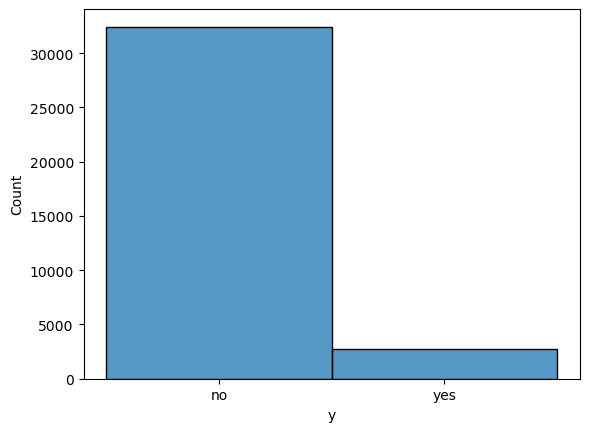

In [10]:
# Examine the distribution of the target variable

sns.histplot(bankdata['y'])

<font color=darkred>This is a very imbalanced data set. Consider leveraging SMOTE or other techniques before fitting the model on training data</font>

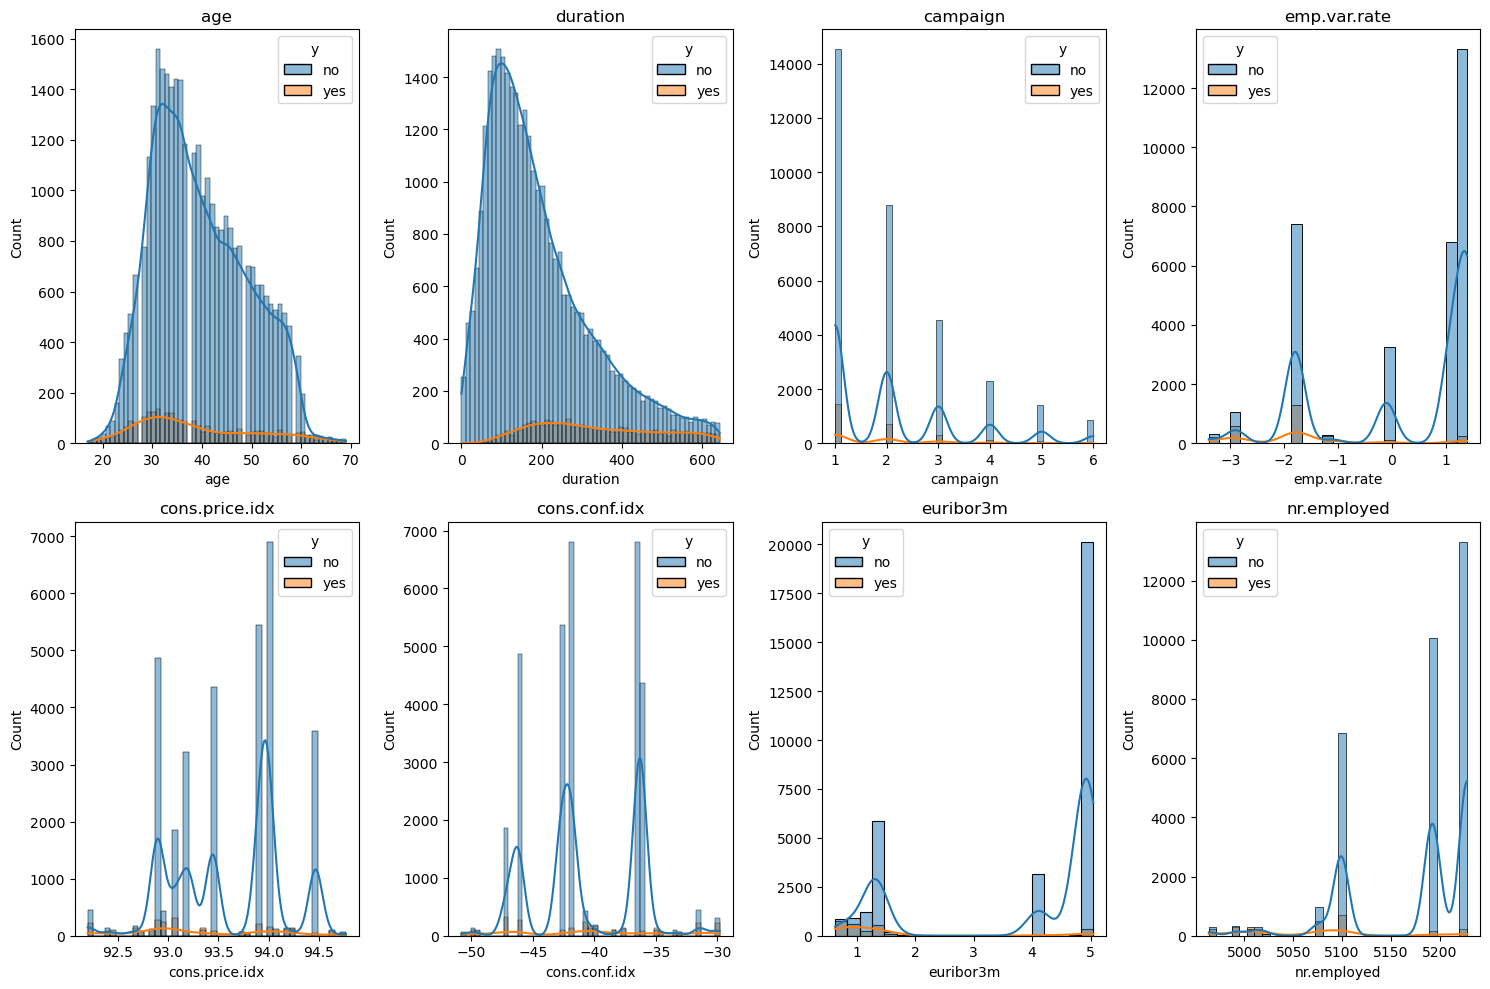

In [11]:
# Plot the distribution of numerical columns

num_cols = 4        # Define the number of rows and columns for the grid
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.histplot(x=bankdata[column], ax=axes[i], hue=bankdata['y'], kde=True)
    axes[i].set_title(f'{column}')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<font color=darkred>**Distributions of Numerical Columns**

- **Age**: Age is centered around 40
- **Duration**: customers with larger durations of the last contact call appear to have higher success rates. 

<Axes: xlabel='y', ylabel='duration'>

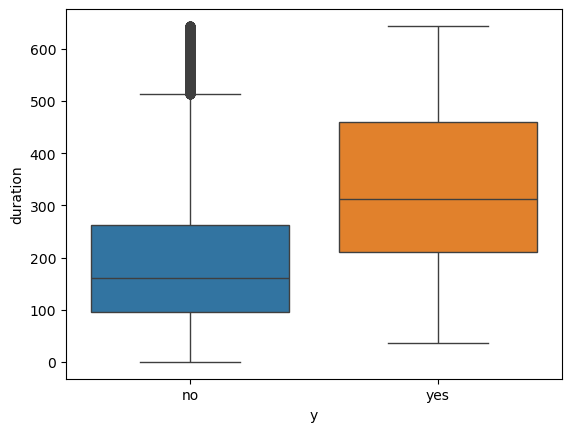

In [12]:

# compare duration column with the target variable

sns.boxplot(y=bankdata['duration'], x=bankdata['y'], hue=bankdata['y'])

<font color=darkred>
As provided in the guideline the duration of the last contact call in this campaign does have a positive corelation to the success of the compaign. Intuitively we also know that the longer a customer servivce representative remains on the call with a customer, the likely hood of success increases. 

We will remove this column from our analysis

<Axes: xlabel='y', ylabel='nr.employed'>

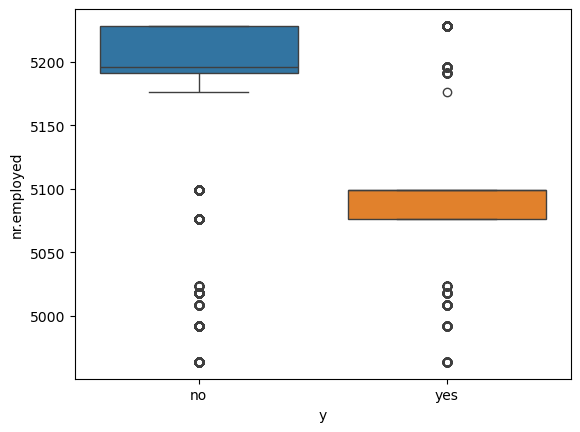

In [166]:
# compare nr.employed in the bank column with the target variable

sns.boxplot(y=bankdata['nr.employed'], x=bankdata['y'], hue=bankdata['y'])

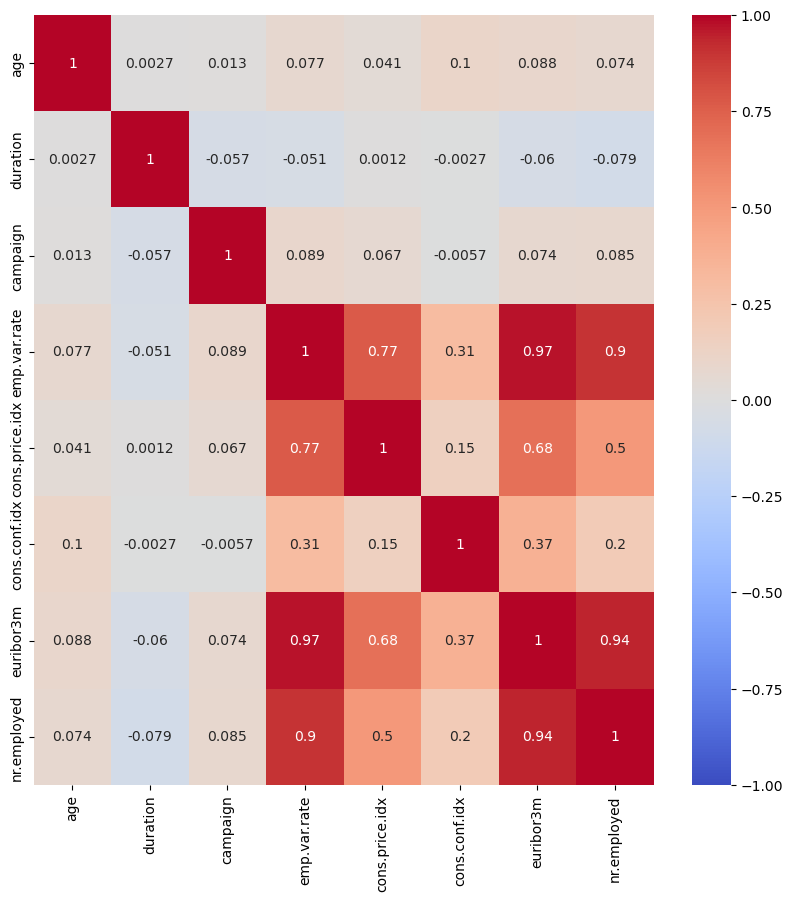

In [13]:
# Review the correlation between numerical columns

plt.figure(figsize=(10, 10))
ax = sns.heatmap(bankdata.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

<font color=darkred>
**Examine colinearity of various numerical columns**

The societal numerical features - emp.var.rate, consumer price index, consumer confidence index are highly correlated to each other. On the flip side, as expected they have no correlation to the client information (age) or campaign info(duration, and campaign)

In [83]:

# # Define the categorical columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

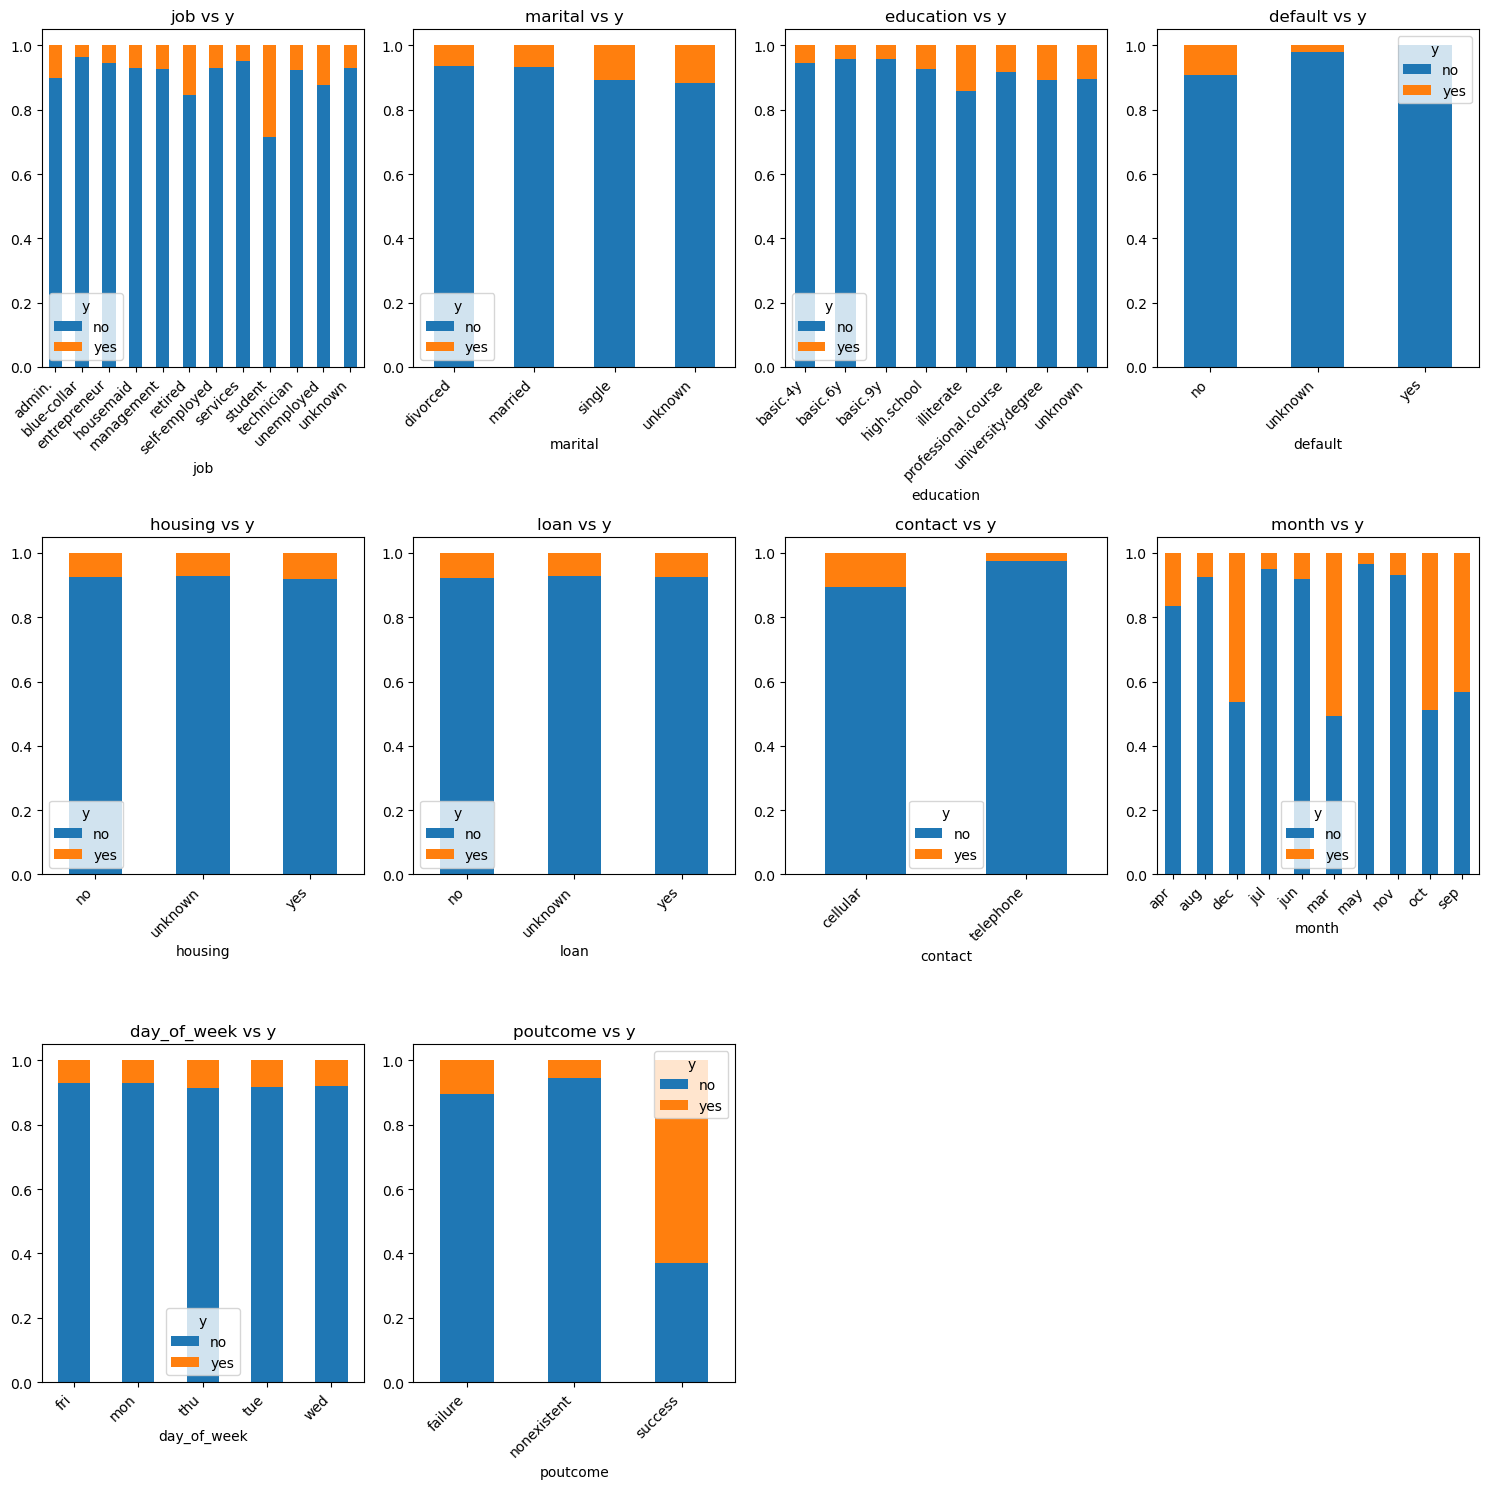

In [15]:
# Examine the categorical variables with y values normalized

# Define the number of rows and columns for the grid
num_cols = 4
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iterationa
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    # Calculate the ratio
    ratio = bankdata.groupby([column, 'y']).size().unstack().apply(lambda x: x / x.sum(), axis=1)
    ratio.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'{column} vs y')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<font color=darkred>

- Campaign calls appear to have higher success with customers who are 
    - illterate, or
    - calls made in dec, jun, sept, oct months
    - calls made on mobiles
    - calls made to students or retired



<Axes: xlabel='month', ylabel='count'>

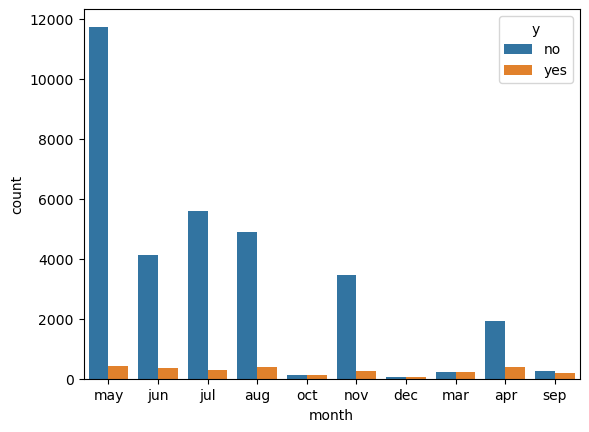

In [16]:
# compare the number of calls made across months, to see if the highest number of calls are made in months with high chance of success

sns.countplot(x='month', hue='y', data=bankdata)

<font color=darkred>
It is interesting to observe that the months with the highest sucess rates, have the least number of calls being made

y                 no   yes
month marital             
mar   divorced   7.0  10.0
      married   70.0  60.0
      single    83.0  74.0
      unknown    1.0   NaN


<Axes: xlabel='month,marital'>

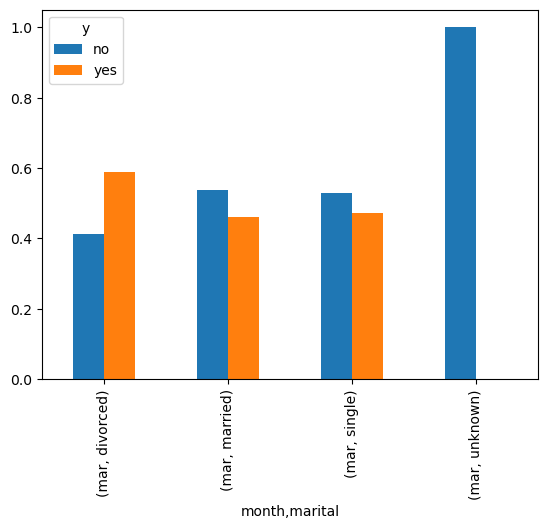

In [84]:
# check distribution of y across marital status in the months where the ratio of success is higher i.e. say March

higher_months = ['mar']

bankdata_higher_months   = bankdata[bankdata['month'].isin(higher_months)]

ratio = bankdata_higher_months.groupby(['month', 'marital','y']).size().unstack()

print(ratio)
ratio.apply(lambda x: x / x.sum(), axis=1).plot(kind='bar')

<font color=darkred>
**Success rate with calls made in Mar, across marital status**

When we look at months with high success rates such as March, within that we observe that success rate is higher with divorced customers

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Business Objective
<font color=darkred>
Create a machine learning model that can help predict success rates for calls made during a marketing campaign. Determine which attributes of customer, campaign or social/economic attributes have the highest influence on the success

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

<font color=darkred>

- drop the duration feature
- change the education feature to an ordinal (in the pipeline)

In [86]:
bankdata.drop(['duration'], axis=1, inplace=True)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [18]:
X = bankdata.drop(columns = 'y')
y = bankdata['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((28132, 18), (7033, 18))

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [19]:
from sklearn.dummy import DummyClassifier

In [20]:
dc = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dc.score(X_test, y_test)

0.9272003412484005

In [88]:
# Transform categorical variables using OneHotEncoder and scale numerical variables using StandardScaler

transformer = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), [col for col in categorical_columns if col != 'education']),
    (OrdinalEncoder(categories=[['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree', 'unknown']]), ['education']),
    remainder=StandardScaler()
)

# transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), categorical_columns),
#                                      remainder = StandardScaler())

### Problem 8: A Simple Model - KNN

Use Logistic Regression to build a basic model on your data.  

In [99]:
#empty dataframe to store the results of all gridsearch modelevaluations
models_evaluated = pd.DataFrame()

In [100]:
# setup a GridSearchCV for the KNN model

params = {'knn__n_neighbors': range(2, 11, 2)}

knn_pipe = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier())])
knn_grid = GridSearchCV(estimator=knn_pipe, param_grid=params, scoring='roc_auc', n_jobs=10, verbose=3)
knn_grid

GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['illiterate',
                                                                                                     'basic.4y',
                                                                                                     'basic.6y',
                                                                                                     'basic.9y',
                                                                                                     'high.school',
                                                                                                     'professional.course',
                                                                                                     'university.degree',
                                                                                                     'unknown']]),
                                                                         ['education'])])),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=10, param_grid={'knn__n_neighbors': range(2, 11, 2)},
             scoring='roc_auc', verbose=3)

In [101]:
# fit the model

startTime = time.time()

knn_grid.fit(X_train, y_train)

endTime = time.time()
fitTime = round(endTime - startTime, 2)

knn_grid.best_params_, knn_grid.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 2/5] END ................knn__n_neighbors=2;, score=0.757 total time=   1.4s
[CV 3/5] END ................knn__n_neighbors=2;, score=0.753 total time=   1.4s
[CV 1/5] END ................knn__n_neighbors=2;, score=0.770 total time=   1.5s
[CV 4/5] END ................knn__n_neighbors=2;, score=0.780 total time=   1.5s
[CV 5/5] END ................knn__n_neighbors=2;, score=0.793 total time=   1.4s
[CV 1/5] END ................knn__n_neighbors=4;, score=0.843 total time=   1.5s
[CV 2/5] END ................knn__n_neighbors=4;, score=0.826 total time=   1.4s
[CV 3/5] END ................knn__n_neighbors=4;, score=0.836 total time=   1.5s
[CV 4/5] END ................knn__n_neighbors=4;, score=0.845 total time=   1.4s
[CV 5/5] END ................knn__n_neighbors=4;, score=0.851 total time=   1.5s
[CV 1/5] END ................knn__n_neighbors=6;, score=0.866 total time=   1.3s
[CV 2/5] END ................knn__n_neighbors=6;,

({'knn__n_neighbors': 10}, 0.9001405364134939)

In [102]:
# predict using test data

startTime = time.time()

y_pred = knn_grid.predict(X_test)

predictTime = round(time.time() - startTime, 2)


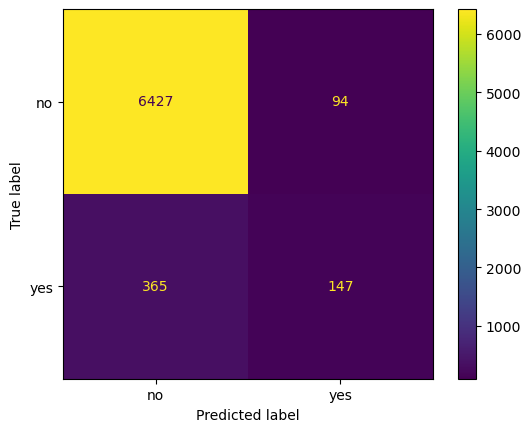

In [103]:
# show the confusion matrix

_classes = knn_grid.best_estimator_.named_steps['knn'].classes_
cm = confusion_matrix(y_test, y_pred, labels = _classes)

disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = _classes)

# show the plot
disp.plot()
plt.show()

In [104]:
# display the scores

train_accuracy = knn_grid.best_score_
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label='yes')
precision = precision_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')

print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

Accuracy: 0.934736243423859
Precision: 0.6099585062240664
Recall: 0.287109375
F1 Score: 0.3904382470119522


In [105]:
# Calculate area under the curve

pred = knn_grid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label='yes')
grid_auc = auc(fpr, tpr)

# find the grid fit time for the best model
grid_fit_time_rank1_model = pd.DataFrame(knn_grid.cv_results_).query('rank_test_score == 1').mean_fit_time.values[0]

In [106]:
# save results in a dataframe

dict = {'model': 'KNN', 
        'train accuracy': train_accuracy, 
        'test accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1': f1,
        'AUC': grid_auc,
        'grid fit time': fitTime,
        'grid predict time': predictTime,
        'best model mean fit time': grid_fit_time_rank1_model,
        'input params': params,
        'best params': knn_grid.best_params_
}

models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

In [97]:
models_evaluated

,model,train accuracy,test accuracy,precision,recall,f1,AUC,grid fit time,grid predict time,best model mean fit time,input params,best params
0,KNN,0.900141,0.934736,0.609959,0.287109,0.390438,0.90158,12.19,0.45,0.122438,"{'knn__n_neighbors': (2, 4, 6, 8, 10)}",{'knn__n_neighbors': 10}


### Problem 8: A Simple Model - Logistic Regression

Use Logistic Regression to build a basic model on your data.  

In [107]:
# setup a GridSearchCV for the Logistic Regression model

params = {'lr__solver': ['liblinear'],
                   'lr__penalty': ['l1', 'l2'],
                   'lr__C': [0.01, 0.1, 1, 10, 100]
                   }

log_pipe = Pipeline([('transform', transformer), ('lr', LogisticRegression())])
lr_grid = GridSearchCV(log_pipe, params, cv=5, scoring='roc_auc', n_jobs=10, verbose=3)
lr_grid


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['illiterate',
                                                                                                     'basic.4y',
                                                                                                     'basic.6y',
                                                                                                     'basic.9y',
                                                                                                     'high.school',
                                                                                                     'professional.course',
                                                                                                     'university.degree',
                                                                                                     'unknown']]),
                                                                         ['education'])])),
                                       ('lr', LogisticRegression())]),
             n_jobs=10,
             param_grid={'lr__C': [0.01, 0.1, 1, 10, 100],
                         'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['liblinear']},
             scoring='roc_auc', verbose=3)

In [108]:
# fit the model
start_time = time.time()

lr_grid.fit(X_train, y_train)

fitTime = round(time.time() - start_time, 2)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 4/5] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear;, score=0.943 total time=   0.3s
[CV 1/5] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear;, score=0.943 total time=   0.3s
[CV 1/5] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear;, score=0.940 total time=   0.4s
[CV 3/5] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear;, score=0.922 total time=   0.4s
[CV 3/5] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear;, score=0.922 total time=   0.2s
[CV 2/5] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear;, score=0.937 total time=   0.4s
[CV 2/5] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear;, score=0.938 total time=   0.3s
[CV 5/5] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear;, score=0.938 total time=   0.2s
[CV 4/5] END lr__C=0.01, lr__penalty=l2, lr__solver=liblinear;, score=0.946 total time=   0.2s
[CV 5/5] END lr__C=0.01, lr__penalty=l1, lr__solver=liblinear;, score=0.934 total ti

In [33]:
lr_grid.best_params_, lr_grid.best_score_

({'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'},
 0.9433007205064939)

In [109]:
# predict using the best estimator on test data
startTime = time.time()
y_pred = lr_grid.predict(X_test)
predictTime = round(time.time() - startTime, 2)

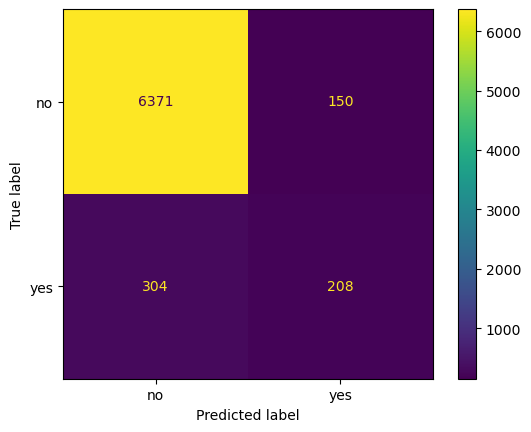

In [110]:
# display the confusion matrix
_classes = lr_grid.best_estimator_.named_steps['lr'].classes_
cm = confusion_matrix(y_test, y_pred, labels = _classes)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = _classes)

disp.plot()
plt.show()

In [111]:
# display the scores
train_accuracy = lr_grid.best_score_
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label='yes')
precision = precision_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')

print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

Accuracy: 0.9354471775913551
Precision: 0.5810055865921788
Recall: 0.40625
F1 Score: 0.4781609195402299


In [112]:
# Calculate area under the curve

pred = lr_grid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label='yes')
grid_auc = auc(fpr, tpr)

# find the grid fit time for the best model
grid_fit_time_rank1_model = pd.DataFrame(lr_grid.cv_results_).query('rank_test_score == 1').mean_fit_time.values[0]

In [113]:
# save model evaluation results in evaluation dataframe

dict = {'model': 'Logistic Regression', 
        'train accuracy': train_accuracy, 
        'test accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1': f1,
        'AUC': grid_auc,
        'grid fit time': fitTime,
        'grid predict time': predictTime,
        'best model mean fit time': grid_fit_time_rank1_model,
        'input params': params,
        'best params': lr_grid.best_params_
}

models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

In [114]:
models_evaluated

,model,train accuracy,test accuracy,precision,recall,f1,AUC,grid fit time,grid predict time,best model mean fit time,input params,best params
0,KNN,0.900141,0.934736,0.609959,0.287109,0.390438,0.901580,10.84,0.55,0.083026,"{'knn__n_neighbors': (2, 4, 6, 8, 10)}",{'knn__n_neighbors': 10}
1,Logistic Regression,0.943342,0.935447,0.581006,0.406250,0.478161,0.940891,8.91,0.03,2.602531,"{'lr__solver': ['liblinear'], 'lr__penalty': [...","{'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver'..."


In [116]:
# get the feature names
feature_names = lr_grid.best_estimator_.named_steps['transform'].get_feature_names_out()

# clean the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]


<font color=darkred>
Logistic regression provides Log Odds. Convert Log Odds to Odds Ratio and determin the top 10 coeefficients

             columns    values
31         month_mar  7.976391
49    cons.price.idx  3.516635
46          duration  3.098774
51         euribor3m  2.366534
34         month_oct  2.140339
27         month_aug  2.009147
5        job_retired  1.328312
35         month_sep  1.312475
52       nr.employed  1.269073
43  poutcome_success  1.237666


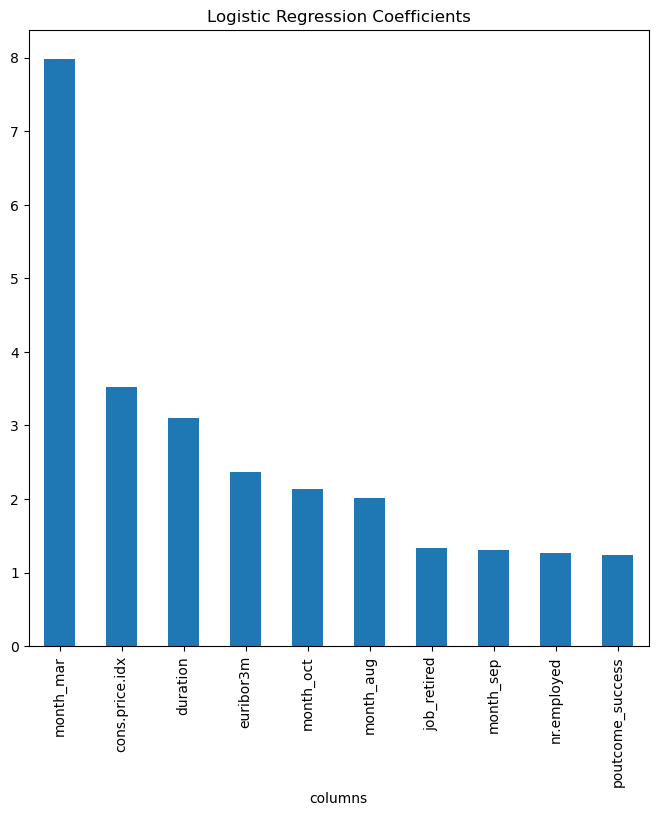

In [ ]:
# get the coefficients
coefficients = lr_grid.best_estimator_.named_steps["lr"].coef_[0]

# convert the coefficients to odds ratio
coefficients = np.exp(coefficients)

# converting coefficients into df 
lr_results = pd.DataFrame({"columns": clean_feature_names, "values" : coefficients}).sort_values(by = "values", ascending = False)

print(lr_results.head(10))

# bar plot
lr_results.head(10).plot(kind='bar', x='columns', y='values', legend=False, figsize=(8, 8))

# Adding labels and title to the plot
plt.title('Logistic Regression Coefficients')

# Display the plot
plt.show()

<font color=darkred>

Odds of success increase:
- 8 times for calls made in March
- 3.4 times for every unit increase in consumer price index (this is counter intuitive and requires further investigation)
- 3.2 times for every unit increase in duration
- 2.1, 2.0 and 1.3 times for calls made in Oct, Aug and Sep respectively
- 1.3 times for calls made to retired customers
- 1.2 times if the prior outcome was successful


In [153]:
lr_results.tail(15).sort_values(by= 'values', ascending = True)   

,columns,values
48,emp.var.rate,0.040394
41,poutcome_failure,0.165437
42,poutcome_nonexistent,0.299166
32,month_may,0.416435
30,month_jun,0.447815
33,month_nov,0.516827
17,default_unknown,0.650962
25,contact_telephone,0.660763
7,job_services,0.691859
1,job_blue-collar,0.712162


<font color=darkred>

Odds of success decrease:
- If previous call was a failure or unknown
- Calls made in may, june, nov
- If contact is made through telephones
- If the customers are in services or blue collar jobs
- if calls are made on Mon, Tue, Fri or in the month of April

### 8 Decision Tree Model

In [171]:
# setup a GridSearchCV for the Decision Tree model

params = {'dt__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
         'dt__max_depth': [6,8,10],
         'dt__min_samples_split': [0.1, 0.2, 0.05]}

#params = {'dt__max_depth': [2,4,6,8,10]}

# transformer = make_column_transformer(
#     (OneHotEncoder(drop='if_binary'), [col for col in categorical_columns if col != 'education']),
#     (OrdinalEncoder(categories=[['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree', 'unknown']]), ['education'])
# )

dt_pipe = Pipeline([('transform', transformer), ('dt', DecisionTreeClassifier(random_state = 42))])
dt_grid = GridSearchCV(estimator=dt_pipe, param_grid=params, scoring='roc_auc', n_jobs=10, verbose=3)

dt_grid

GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['illiterate',
                                                                                                     'basic.4y',
                                                                                                     'basic.6y',
                                                                                                     'basic.9y',
                                                                                                     'high.school',
                                                                                                     'professional.course',
                                                                                                     'university.degree',
                                                                                                     'unknown']]),
                                                                         ['education'])])),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=10, param_grid={'dt__max_depth': [2, 4, 6, 8, 10]},
             scoring='roc_auc', verbose=3)

In [172]:
# fit the model

start_time = time.time()

dt_grid.fit(X_train, y_train)

fitTime = round(time.time() - start_time, 2)

dt_grid.best_params_, dt_grid.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...................dt__max_depth=4;, score=0.761 total time=   0.2s
[CV 2/5] END ...................dt__max_depth=2;, score=0.612 total time=   0.1s
[CV 4/5] END ...................dt__max_depth=2;, score=0.656 total time=   0.2s
[CV 1/5] END ...................dt__max_depth=2;, score=0.676 total time=   0.2s
[CV 5/5] END ...................dt__max_depth=2;, score=0.664 total time=   0.2s
[CV 3/5] END ...................dt__max_depth=2;, score=0.641 total time=   0.2s
[CV 3/5] END ...................dt__max_depth=4;, score=0.696 total time=   0.2s
[CV 2/5] END ...................dt__max_depth=4;, score=0.634 total time=   0.2s
[CV 4/5] END ...................dt__max_depth=4;, score=0.707 total time=   0.1s
[CV 5/5] END ...................dt__max_depth=4;, score=0.768 total time=   0.1s
[CV 2/5] END ...................dt__max_depth=6;, score=0.732 total time=   0.1s
[CV 1/5] END ...................dt__max_depth=6;,

({'dt__max_depth': 8}, 0.7861447534351512)

In [173]:
# predict using test data

startTime = time.time()

y_pred = dt_grid.predict(X_test)

predictTime = round(time.time() - startTime, 2)

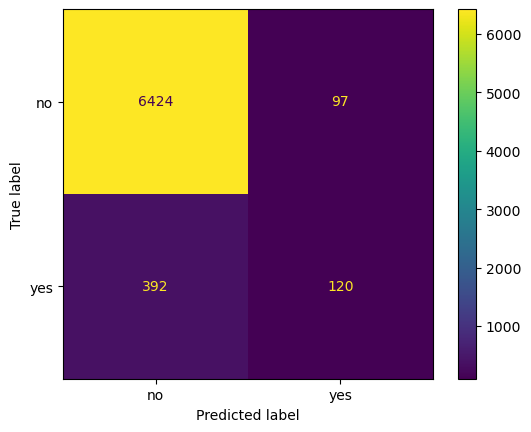

In [174]:
# display the confusion matrix

_classes = dt_grid.best_estimator_.named_steps['dt'].classes_
cm = confusion_matrix(y_test, y_pred, labels = _classes)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = _classes)

disp.plot()
plt.show()

In [175]:
# display the scores
train_accuracy = dt_grid.best_score_
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label='yes')
precision = precision_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')

print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

Accuracy: 0.9304706384188824
Precision: 0.5529953917050692
Recall: 0.234375
F1 Score: 0.3292181069958848


In [176]:
# Calculate area under the curve

pred = dt_grid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label='yes')
grid_auc = auc(fpr, tpr)

# find the grid fit time for the best model
grid_fit_time_rank1_model = pd.DataFrame(dt_grid.cv_results_).query('rank_test_score == 1').mean_fit_time.values[0]

In [177]:

dict = {'model': 'Decision Tree', 
        'train accuracy': train_accuracy, 
        'test accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1': f1,
        'AUC': grid_auc,
        'grid fit time': fitTime,
        'grid predict time': predictTime,
        'best model mean fit time': grid_fit_time_rank1_model,
        'input params': params,
        'best params': dt_grid.best_params_
}

models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

In [178]:
models_evaluated

,model,train accuracy,test accuracy,precision,recall,f1,AUC,grid fit time,grid predict time,best model mean fit time,input params,best params
0,KNN,0.900141,0.934736,0.609959,0.287109,0.390438,0.901580,10.84,0.55,0.083026,"{'knn__n_neighbors': (2, 4, 6, 8, 10)}",{'knn__n_neighbors': 10}
1,Logistic Regression,0.943342,0.935447,0.581006,0.406250,0.478161,0.940891,8.91,0.03,2.602531,"{'lr__solver': ['liblinear'], 'lr__penalty': [...","{'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver'..."
2,Decision Tree,0.927961,0.941277,0.632000,0.462891,0.534386,0.923341,1.39,0.03,0.176179,"{'dt__max_depth': [2, 4, 6, 8, 10]}",{'dt__max_depth': 6}
3,Decision Tree,0.786145,0.930471,0.552995,0.234375,0.329218,0.799469,8.60,0.03,0.131610,"{'dt__max_depth': [2, 4, 6, 8, 10]}",{'dt__max_depth': 8}


In [180]:
# export the tree
dt_grid.best_estimator_.named_steps['transform'].get_feature_names_out()

# clean the feature names
clean_feature_names = [name.split('__')[-1] for name in feature_names]
print(clean_feature_names)

dt = dt_grid.best_estimator_.named_steps['dt']

depth = export_text(dt, feature_names=clean_feature_names)
export_text(dt, feature_names=clean_feature_names, show_weights=True)

print(depth)

['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success', 'education', 'age', 'duration', 'campaign', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


ValueError: feature_names must contain 45 elements, got 53

In [169]:
# check for the importance of features

features_importance = pd.DataFrame({'feature': clean_feature_names, 'importance': dt.feature_importances_})
    
features_importance.sort_values(by='importance', ascending=False).head(10)

,feature,importance
52,nr.employed,0.471591
46,duration,0.316567
51,euribor3m,0.055329
43,poutcome_success,0.049972
50,cons.conf.idx,0.049568
34,month_oct,0.019147
45,age,0.010531
49,cons.price.idx,0.005153
26,month_apr,0.005114
37,day_of_week_mon,0.004813


<font color=darkred>

The Decision tree model gives the most importance to 
- number of people employed in the bank at the root node
- duration
- euribor3 month rate
- prior campaign outcome
- consumer confidence



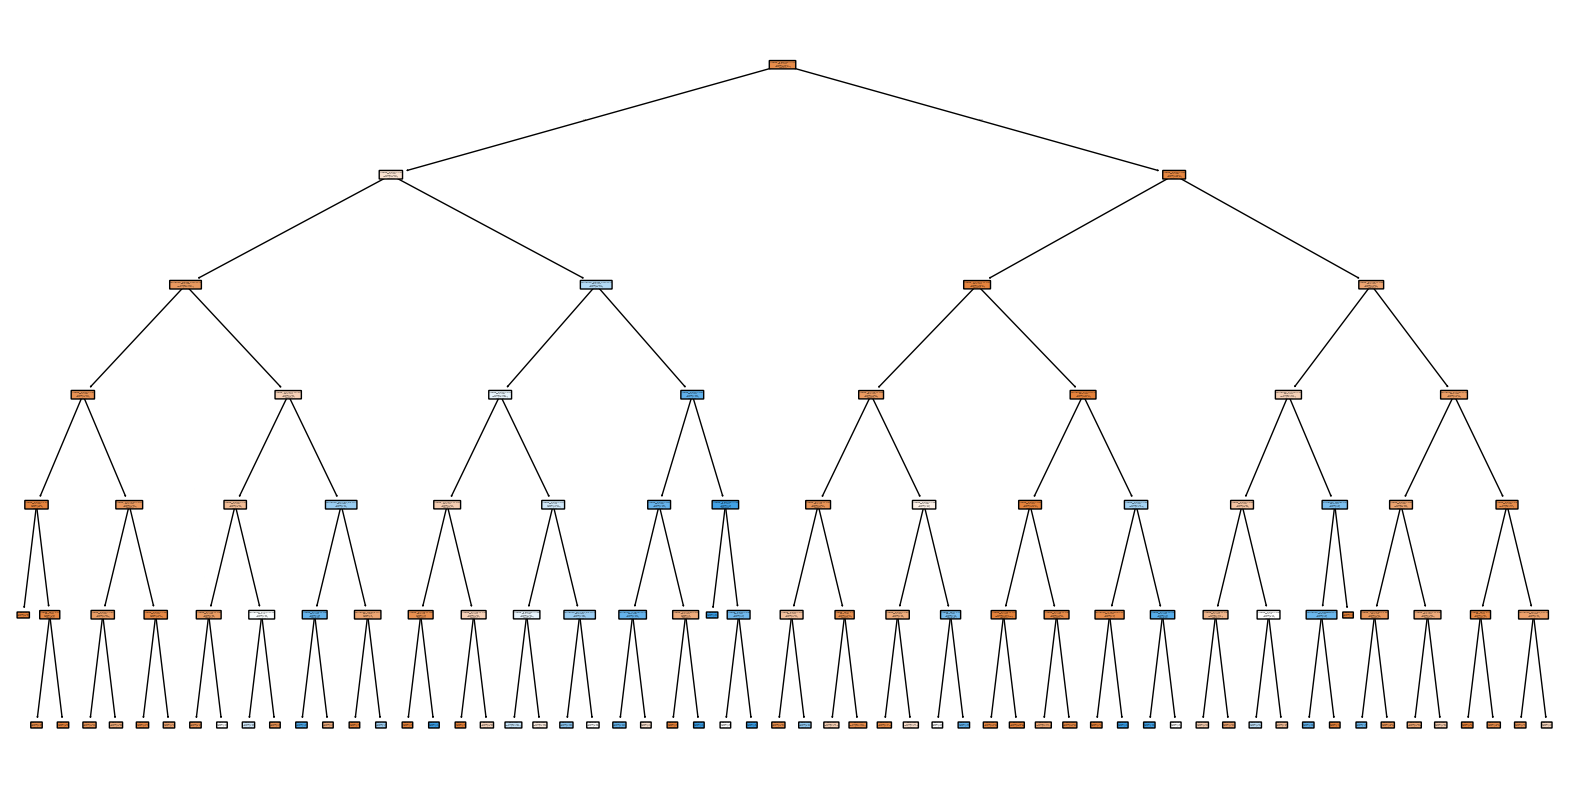

In [154]:
from sklearn.tree import plot_tree

# Get the best decision tree model
dt = dt_grid.best_estimator_.named_steps['dt']

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=dt_grid.best_estimator_.named_steps['transform'].get_feature_names_out(), class_names=dt.classes_, filled=True, rounded=True)
plt.show()

### 8 SVM

In [181]:
# setup a GridSearchCV for the SVM model

params = {'svm__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
         'svm__gamma': [0.1, 1.0, 10.0],}

# params = {'svm__kernel': ['rbf', 'linear', 'poly'],
#          'svm__gamma': [1.0],}

svm_pipe = Pipeline([('transform', transformer), ('svm', SVC(random_state = 42, probability=True))])

svm_grid = GridSearchCV(estimator=svm_pipe, param_grid=params, scoring='roc_auc', n_jobs=10, verbose=2)

svm_grid

GridSearchCV(estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['job',
                                                                          'marital',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['illiterate',
                                                                                                     'basic.4y',
                                                                                                     'basic.6y',
                                                                                                     'basic.9y',
                                                                                                     'high.school',
                                                                                                     'professional.course',
                                                                                                     'university.degree',
                                                                                                     'unknown']]),
                                                                         ['education'])])),
                                       ('svm',
                                        SVC(probability=True,
                                            random_state=42))]),
             n_jobs=10,
             param_grid={'svm__gamma': [0.1, 1.0, 10.0],
                         'svm__kernel': ['rbf', 'poly', 'linear', 'sigmoid']},
             scoring='roc_auc', verbose=2)

In [130]:
# fit the model

start_time = time.time()

svm_grid.fit(X_train, y_train)

fitTime = round(time.time() - start_time, 2)

svm_grid.best_params_, svm_grid.best_score_

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .................svm__gamma=1.0, svm__kernel=linear; total time=  50.1s
[CV] END .................svm__gamma=1.0, svm__kernel=linear; total time=  51.5s
[CV] END .................svm__gamma=1.0, svm__kernel=linear; total time=  51.9s
[CV] END .................svm__gamma=1.0, svm__kernel=linear; total time=  52.0s
[CV] END .................svm__gamma=1.0, svm__kernel=linear; total time=  52.8s


KeyboardInterrupt: 

In [54]:
# predict using test data

start_time = time.time()
y_pred = svm_grid.predict(X_test)

predictTime = round(time.time() - start_time, 2)

grid_score = svm_grid.score(X_test, y_test)

print(grid_score)

0.9370225761002914


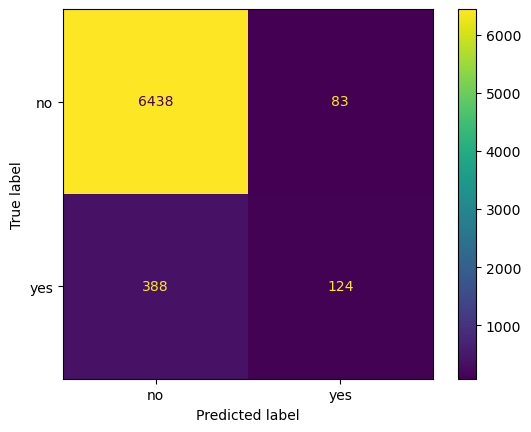

In [55]:
# display the confusion matrix

_classes = svm_grid.best_estimator_.named_steps['svm'].classes_
cm = confusion_matrix(y_test, y_pred, labels = _classes)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = _classes)

disp.plot()
plt.show()

In [56]:
# display the scores
train_accuracy = svm_grid.best_score_
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label='yes')
precision = precision_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')

print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

Accuracy: 0.9330300014218683
Precision: 0.5990338164251208
Recall: 0.2421875
F1 Score: 0.34492350486787204


In [57]:
# Calculate area under the curve

pred = svm_grid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label='yes')
grid_auc = auc(fpr, tpr)

# find the grid fit time for the best model
grid_fit_time_rank1_model = pd.DataFrame(svm_grid.cv_results_).query('rank_test_score == 1').mean_fit_time.values[0]

In [58]:
# store results in the evaluation dataframe

dict = {'model': 'SVM', 
        'train accuracy': train_accuracy, 
        'test accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1': f1,
        'AUC': grid_auc,
        'grid fit time': fitTime,
        'grid predict time': predictTime,
        'best model mean fit time': grid_fit_time_rank1_model,
        'input params': params,
        'best params': svm_grid.best_params_
}

models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)

### Problem 9: Score the Model

What is the accuracy of your model?

In [60]:
models_evaluated

,model,train accuracy,test accuracy,precision,recall,f1,AUC,grid fit time,grid predict time,best model mean fit time,input params,best params
0,KNN,0.899954,0.934594,0.605691,0.291016,0.393140,0.908700,213.65,7.29,0.162390,"{'knn__n_neighbors': (2, 4, 6, 8, 10)}",{'knn__n_neighbors': 10}
1,Logistic Regression,0.943301,0.936442,0.590529,0.414062,0.486797,0.941337,10.73,0.01,2.298264,"{'lr__solver': ['liblinear'], 'lr__penalty': [...","{'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver'..."
2,Decision Tree,0.927980,0.941277,0.632000,0.462891,0.534386,0.923375,1.07,0.01,0.131157,"{'dt__max_depth': [2, 4, 6, 8, 10]}",{'dt__max_depth': 6}
3,SVM,0.937423,0.933030,0.599034,0.242188,0.344924,0.937023,203.00,1.34,58.717852,"{'svm__kernel': ['poly', 'linear'], 'svm__gamm...","{'svm__gamma': 1.0, 'svm__kernel': 'linear'}"


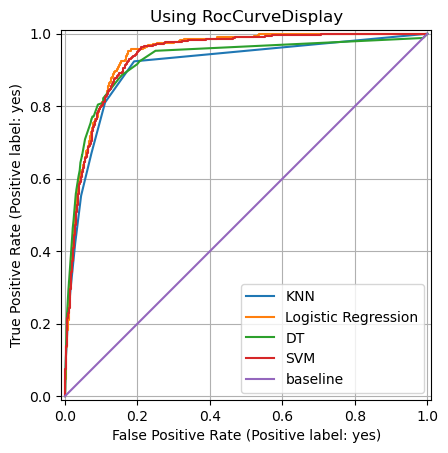

In [61]:
# create ROC curve for all the models

fig, ax = plt.subplots()

RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, pos_label = 'yes', ax = ax, label = 'KNN')
RocCurveDisplay.from_estimator(lr_grid, X_test, y_test, pos_label = 'yes', ax = ax, label = 'Logistic Regression')
RocCurveDisplay.from_estimator(dt_grid, X_test, y_test, pos_label = 'yes', ax = ax, label = 'DT')
RocCurveDisplay.from_estimator(svm_grid, X_test, y_test, pos_label = 'yes', ax = ax, label = 'SVM')
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Using RocCurveDisplay')
plt.legend();

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [62]:
# helper function to run and evaluate models, pipelines and gridsearchcv

def run_and_eval_model(model, model_name, X_train, X_test, y_train, y_test):
    
    start_time = time.time()

    # fit the selected model 
    model.fit(X_train, y_train.values.ravel())
    
    fit_time = round(time.time() - start_time, 2)
    start_time = time.time()
    
    train_score = cross_val_score(model, X_train, y_train.values.ravel(), cv=5, scoring='accuracy').mean()
    
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    recall = recall_score(y_test, y_pred, pos_label='yes')
    precision = precision_score(y_test, y_pred, pos_label='yes')
    f1 = f1_score(y_test, y_pred, pos_label='yes')
    
    eval_time = round(time.time() - start_time, 2)
    
    print(f"{model_name} with train accuracy score {train_score:.3f}, took {time.time()-start_time:.3f} seconds")
    
    return {'model': model_name, 
            'train accuracy': train_score, 
            'test accuracy': test_accuracy,
            'precision': precision, 
            'recall': recall,
            'f1': f1,
            'fit time': fit_time,
            'eval time': eval_time}

In [63]:
# Define the pipelines for all classification models with default hyperparameters

pipelines = {
    'KNN': Pipeline([('transform', transformer), ('classifier', KNeighborsClassifier())]),
    'Logistic Regression': Pipeline([('transform', transformer), ('classifier', LogisticRegression())]),
    'Decision Trees': Pipeline([('transform', transformer), ('classifier', DecisionTreeClassifier())]),
    'SVM': Pipeline([('transform', transformer), ('classifier', SVC())])
}

models_evaluated = pd.DataFrame()

for model_name, pipeline in pipelines.items():
    dict = run_and_eval_model(pipeline, model_name, X_train, X_test, y_train, y_test)
    models_evaluated = pd.concat([models_evaluated, pd.DataFrame([dict])], ignore_index=True)
    
    
models_evaluated



KNN with train accuracy score 0.932, took 32.565 seconds
Logistic Regression with train accuracy score 0.938, took 0.725 seconds
Decision Trees with train accuracy score 0.919, took 1.496 seconds
SVM with train accuracy score 0.940, took 34.062 seconds


,model,train accuracy,test accuracy,precision,recall,f1,fit time,eval time
0,KNN,0.931679,0.932461,0.551532,0.386719,0.454650,0.07,32.57
1,Logistic Regression,0.938220,0.936585,0.592179,0.414062,0.487356,0.14,0.72
2,Decision Trees,0.919238,0.917532,0.442373,0.509766,0.473684,0.35,1.50
3,SVM,0.939819,0.939286,0.627628,0.408203,0.494675,8.75,34.06


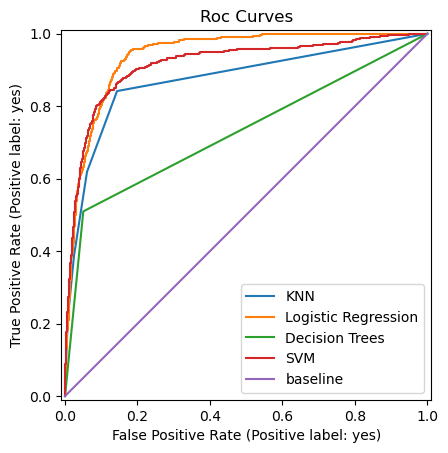

In [64]:
# display ROC curve for each model

fig, ax = plt.subplots()
for model_name, pipeline in pipelines.items():
    RocCurveDisplay.from_estimator(pipeline, X_test, y_test, pos_label = 'yes', ax = ax, label = model_name)
    plt.grid()

plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Roc Curves')
plt.legend()

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions